In [1]:
import numpy as np
import time
import math
from sklearn.base import BaseEstimator


def loss(y,mu):
    return sum(y/mu)


def noNoiseGammaSimple(X, y, phi, w_init, w_star, max_iter_budget, step_gd,cleanIdx,corrIdx):
    start_time=time.time()
    n,d = X.shape
    w1=w2=w_init
    l2=[]
    clock=[]
    itr=0
    while itr < max_iter_budget:

        w1=w2

        mu=np.exp(-1*np.dot(X, w1))*(1-phi)
        w2=w1-(step_gd/n)*(sum((y/mu-1)*X).reshape((d,1)))      # gradient descent
        
           
        l2.append(np.linalg.norm(w2-w_star))
        clock.append(time.time()-start_time)             
       
        itr+=1
            
    return [l2,clock]

def HT(a,k):
    t=np.zeros(a.shape)
    if k==0:
        return t
    else:
        ind=np.argpartition(abs(a),-k, axis=None)[-k:]    
        t[ind]=a[ind]
    return t

class SVAM_GAMMA(BaseEstimator):
# w_star is used only to plot convergence curves and not tune the method or decide stopping criterion in any way
    def __init__( self, beta_init = 1 , alpha=0, eta = 1.9, step_gd=10, phi=0.5, w_init = None, w_star = None ):
        self.eta = eta
        self.alpha = alpha
        self.phi=phi
        self.beta_init = beta_init
        self.step_gd=step_gd
        self.w_init = w_init
        self.w_star = w_star

    def fit( self, X, y, beta_max=150, max_iter_budget = 50, max_iter_inner = 2 ):
        start_time=time.time()
        n, d = X.shape
        beta = self.beta_init
        phi=self.phi
        self.w1 = self.w_init
        self.w2 = self.w_init
        self.l2=[]
        self.clock=[]
        itr=0         
        while itr < max_iter_budget:

            for _ in range(max_iter_inner):
                self.w1=self.w2
                mu_t= np.exp(-1*np.dot(X, self.w1))*(1-phi+phi/beta)       # mean of variance-reduced dist.
                phi_t=phi/(beta+phi-phi*beta)                         #shape of variance-reduced dist.
                t=y/(phi_t*mu_t)
                s=np.exp(np.log(t)/phi_t - t)/(y*math.gamma(1/phi_t)) #likelihood on variance-reduced dist.
                mu=np.exp(-1*np.dot(X, self.w1))*(1-phi)
                self.w2=self.w1-(self.step_gd/sum(s))*(sum((y/mu-1)*s*X).reshape((d,1)))      # gradient descent on weighted likihood
                self.l2.append(np.linalg.norm(self.w2-self.w_star))
                self.clock.append(time.time()-start_time)

            itr=itr+max_iter_inner
            beta=min(beta_max,self.eta*beta)
        return self

    def predict( self, X ):
        return np.exp(-1*np.dot(X, self.w1))*(1-self.phi)
    
    def score( self, X, y ):
        n_test = X.shape[0]
        n_test_corr = int( self.alpha * n_test )
        res = y - self.predict(X)
        res_corr = HT( res, n_test_corr )
        return -np.linalg.norm( res - res_corr, 2) / np.sqrt( n_test - n_test_corr )

In [2]:
import numpy as np
import matplotlib.pyplot as plt

n=1000
d=10
alpha =0.2
phi=0.5

n_corr  = int(alpha*n)

Idx= np.random.permutation(n)
corrIdx= np.sort(Idx[0:n_corr])
cleanIdx=np.sort(Idx[n_corr:n])

X = np.random.normal(0,1, (n, d))/np.sqrt(d)

w_star= np.random.normal(0,1, (d, 1))
w_star = w_star / np.linalg.norm(w_star)

w_adv= np.random.normal(0,1, (d, 1))
w_adv -= np.dot(w_adv.transpose(),w_star)*w_star
w_adv = w_adv / np.linalg.norm(w_adv)

mu=np.zeros(shape=(n,1))
mu[cleanIdx]=np.exp(-1*np.dot(X[cleanIdx], w_star))
mu[corrIdx]=np.exp(-1*np.dot(X[corrIdx], w_adv))

y=mu*(1-phi)


In [3]:
#----------MLE------------#
max_iter_budget=50
step_gd=10
w_init=w_adv
[l2_mle,clock_mle]=noNoiseGammaSimple(X, y, phi,w_init, w_star, max_iter_budget, step_gd,cleanIdx,corrIdx)

In [4]:
#----------VAM-------------#
betas=[1,10,100]
l2_ems_list=[]
clock_ems_list=[]
for i in range(len(betas)):
    vam = SVAM_GAMMA( beta_init = betas[i], eta = 1, step_gd=10, w_init = w_adv, w_star = w_star )
    vam.fit( X, y,  max_iter_budget = 50)
    l2_ems_list.append(vam.l2)
    clock_ems_list.append(vam.clock)

In [5]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

cross_validation=True
if cross_validation:
    eta_range = np.linspace( 1.1, 5, 10 )
    alpha_range= np.linspace( alpha, alpha, 1 )
    beta_init_range = np.power( 10.0, [ -1, 0] )
    step_gd_range=np.linspace( 1.1, 10, 5 )
    
    param_grid = dict( beta_init = beta_init_range,  alpha=alpha_range, eta = eta_range, step_gd=step_gd_range)
    cv = ShuffleSplit( n_splits = 1, test_size = 0.3, random_state = 42 )
    grid = GridSearchCV( SVAM_GAMMA( w_init = w_adv, w_star = w_star ), param_grid=param_grid, cv = cv, refit = False )
    grid.fit( X, y )
    best = grid.best_params_
    print("The best parameters for SVAM are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
    svam = SVAM_GAMMA( beta_init = best['beta_init'], alpha=best["alpha"], eta = best["eta"], step_gd=best["step_gd"], w_init = w_adv, w_star = w_star )
else:
    svam = SVAM_GAMMA( beta_init = 1, alpha=alpha, eta = 1.9, step_gd=10, w_init = w_adv, w_star = w_star )

svam.fit( X, y,  max_iter_budget = 50)
l2_svam = svam.l2
clock_svam = svam.clock
print('SVAM_LR: ',l2_svam[-1],'Time taken: ',clock_svam[-1])

The best parameters for SVAM are {'alpha': np.float64(0.2), 'beta_init': np.float64(0.1), 'eta': np.float64(1.9666666666666668), 'step_gd': np.float64(3.325)} with a score of -0.00
SVAM_LR:  0.004192640474036842 Time taken:  0.0642552375793457


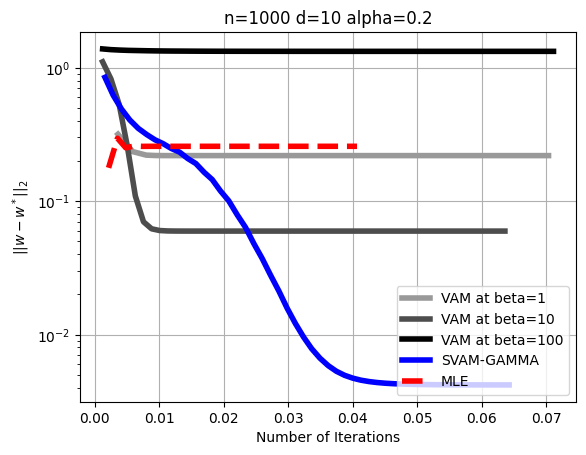

In [6]:
colors=np.arange(len(betas))*0.3
for i in range(len(betas)):    
    plt.semilogy(clock_ems_list[i], l2_ems_list[i], label = 'VAM at beta={}'.format(str(betas[i])), color=str(colors[-i-1]), linewidth=4,marker=',')

plt.semilogy(clock_svam, l2_svam, label = 'SVAM-GAMMA', color='blue',linewidth=4)
plt.semilogy(clock_mle, l2_mle, label = 'MLE', color='red',markersize=12, ls='--', linewidth=4)


plt.xlabel('Number of Iterations')
plt.ylabel('$||w-w^*||_2$')
plt.legend(loc='lower right',prop = {'size': 10})
plt.grid()
config='n='+str(n)+' d='+str(d)+' alpha='+str(alpha)
plt.title(config)
#plt.savefig('no_noise_gamma_str'+config+'.pdf')
plt.show()